In [2]:
#Initial Setup
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from time import process_time

In [3]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])# keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [4]:
df = pd.read_csv('dass.csv')
df.head()

,Q24E,Q25A,Q25I,Q25E,Q26A,Q26I,Q26E,Q27A,Q27I,Q27E,...,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat,dep_cond,anx_cond,str_cond
0,2444,4,1,9880,4,2,4695,4,5,1677,...,No Degree,27,3,34,4,40,4,3 Severe,4 Extremely Severe,4 Extremely Severe
1,2670,2,7,7649,3,11,2537,3,5,2907,...,No Degree,24,3,17,3,27,3,3 Severe,3 Severe,3 Severe
2,8834,2,29,7358,1,30,4928,2,15,3036,...,No Degree,39,4,12,2,17,1,4 Extremely Severe,2 Moderate,1 Mild
3,5630,1,18,30631,2,24,9870,4,4,2411,...,Biology,16,2,17,3,16,1,2 Moderate,3 Severe,1 Mild
4,4047,4,31,3787,4,42,2102,2,1,12351,...,Psychology,32,4,40,4,29,3,4 Extremely Severe,4 Extremely Severe,3 Severe


In [4]:
df.dtypes.value_counts()

int64     176
object      2
dtype: int64

In [5]:
df['country']=pd.factorize(df['country'], sort=True)[0]+1
df['major']=pd.factorize(df['major'], sort=True)[0]+1
df.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,28,3890,4,25,2122,2,16,1944,4,...,2,1,2,46,27,3,34,4,40,4
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,4,46,24,3,17,3,27,3
2,3,7,5784,1,33,4373,4,41,3242,1,...,1,1,3,46,39,4,12,2,17,1
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,5,10,16,2,17,3,16,1
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,1,4,56,32,4,40,4,29,3


In [6]:
df.dtypes.value_counts()

int64    178
dtype: int64

In [7]:
# Target variable will determine severe depression. Levels 3 or 4 indicates severe depression.  So 1 means the individual has 
# severe depression, while 0 means they do not.

for i in range(len(df)):
    if df['Depression_cat'][i] == 3 or df['Depression_cat'][i] == 4:
        df['Depression_cat'][i] = 1
    else:
        df['Depression_cat'][i] = 0
        
df['Depression_cat']

0        1
1        1
2        1
3        0
4        1
        ..
39732    1
39733    1
39734    0
39735    0
39736    1
Name: Depression_cat, Length: 39737, dtype: int64

In [8]:
scaler = MinMaxScaler()
df_rescaled = scaler.fit_transform(df)

In [9]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(df_rescaled)
reduced_ninety_five = pca.transform(df_rescaled)
no_comp = reduced_ninety_five.shape[1]
no_comp

105

This shows that 105 components will be sufficient to capture 95% of the variance.

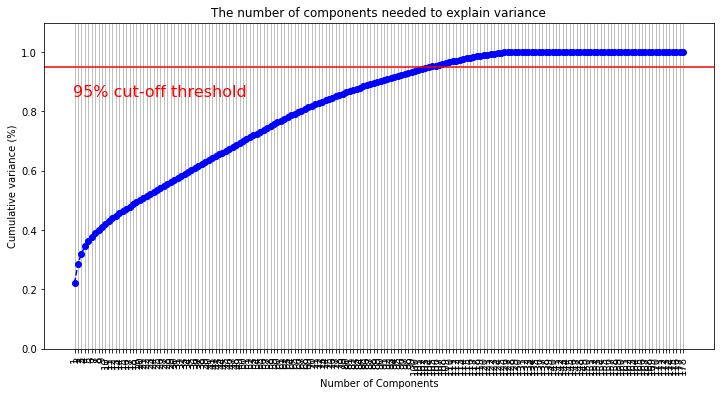

In [10]:
# Visualizing the PCA determination of number of components

pca = PCA().fit(df_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 179, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 179, step=1), rotation=90) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [11]:
# Slice feature columns from dataframe for X
X = df.iloc[:,:172]

# Three different output columns to examine
y = df['Depression_cat']

# Check balance of dataset
y.value_counts()

1    20039
0    19698
Name: Depression_cat, dtype: int64

The data looks very well-balanced, so I may not need to perform SMOTE-ENN after all.  To be thorough, I'll examine the value counts before and after SMOTE-ENN.

In [12]:
# Perform SMOTE-ENN on the dataset
resample=SMOTEENN(random_state=42)

X_res, y_res = resample.fit_resample(X,y)

print(y_res.value_counts())

1    3763
0    2716
Name: Depression_cat, dtype: int64


The balance of the data appears to be worse after SMOTE-ENN.  Nevertheless, my plan is to compare the performance on the model for both pre-SMOTE-ENN and post-SMOTE-ENN data.

In [13]:
# Create a training and test sets for pre-SMOTE-ENN data to examine DEPRESSION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Apply Principal Component Analysis
pca = PCA(n_components = no_comp)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [24]:
# Examine feature importance
dtc=DecisionTreeClassifier()
dtc.fit(X_train_scaled,y_train)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': dtc.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)

print(importances)

    Attribute  Importance
111      Q38A    0.547588
69       Q24A    0.119445
99       Q34A    0.069032
123      Q42A    0.030150
27       Q10A    0.019286
..        ...         ...
24        Q9A    0.000000
28       Q10I    0.000000
87       Q30A    0.000000
84       Q29A    0.000000
0         Q1A    0.000000

[172 rows x 2 columns]


In [19]:
t1_start = process_time() 

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_scaled,y_train)
y_pred=rfc.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

RMSE =  0.16687623127436346
Processing time =  12.453125


In [20]:
# Create a training and test sets for post-SMOTE-ENN data to examine DEPRESSION
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
t1_start = process_time() 

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_scaled,y_train)
y_pred=rfc.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

RMSE =  0.16037507477489604
Processing time =  1.546875


In [ ]:
# Compute 5-fold cross-validation scores=
cv_scores = cross_val_score(lin_reg, X, y, cv=5)
print("5-Fold CV Scores: ", cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

In [ ]:
ay = df['Anxiety_cat']
sy = df['Stress_cat']